# 1. Logistic and Softmax Regression via Gradient Descent

## Load packages

In [1]:
from collections import defaultdict
from mnist.loader import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

## Read in the data from the files

In [2]:
mndata = MNIST('mnist')

trainData, trainLabel = mndata.load_training()

testData, testLabel = mndata.load_testing()

## Show a random templete of digits in training set

The index is 52080.


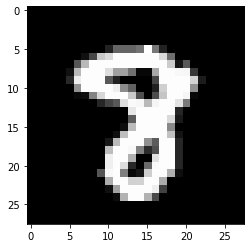

The label of the image is 8


In [3]:
idx = np.random.randint(len(trainData),size = 1)[0]
print ("The index is %d." % (idx))

img = np.reshape(trainData[idx],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.show()

print ("The label of the image is %d" % (trainLabel[idx]))

## Design data pre-processing class to fit assingment requirement

In [4]:
class data_process():
    def __init__(self, trainD, trainL, testD, testL, addBias = True, shuffle = True):
        if addBias:
            self.trainData = np.insert(np.asarray(trainD), 0, 1, axis=1)
            self.testData = np.insert(np.asarray(testD), 0, 1, axis=1)
        else:
            self.trainData = np.asarray(trainD)
            self.testData = np.asarray(testD)
        self.trainLabel = np.asarray(trainL).reshape((len(trainL), -1))
        self.testLabel = np.asarray(testL).reshape((len(testL), -1))
        if shuffle:
            self.shuffle()

    def shuffle(self):
        idxTrain = np.random.permutation(len(self.trainData))
        idxTest = np.random.permutation(len(self.testData))
        self.trainData = self.trainData[idxTrain]
        self.trainLabel = self.trainLabel[idxTrain]
        self.testData = self.testData[idxTest]
        self.testLabel = self.testLabel[idxTest]
        
    def targetSelect(self, target1 = 0, target2 = 1):
        trainD = []
        trainL = []
        testD = []
        testL = []
        for data, label in zip(self.trainData, self.trainLabel):
            if label == target1:
                trainL.append(1)
                trainD.append(data)
            if label == target2:
                trainL.append(0)
                trainD.append(data)
        for data, label in zip(self.testData, self.testLabel):
            if label == target1:
                testL.append(1)
                testD.append(data)
            if label == target2:
                testL.append(0)
                testD.append(data)
        trainD = np.asarray(trainD)
        trainL = np.asarray(trainL).reshape((len(trainL),-1))
        testD = np.asarray(testD)
        testL = np.asarray(testL).reshape((len(testL),-1))
        return trainD, trainL, testD, testL
    
    def oneHot(self):
        classes = len(np.unique(self.trainLabel))
        trainL = np.zeros((len(self.trainLabel), classes))
        testL = np.zeros((len(self.testLabel), classes))
        for i, label in enumerate(self.trainLabel):
            trainL[i][label] = 1
        for i, label in enumerate(self.testLabel):
            testL[i][label] = 1
        return trainL, testL

In [5]:
data = data_process(trainData, trainLabel, testData, testLabel, addBias = True, shuffle = True)

In [6]:
data = data_process(trainData[:20000], trainLabel[:20000], testData[-2000:], testLabel[-2000:], addBias = True, shuffle = True)

# 2-Class Logistic Regression via Gradient Descent

In [7]:
class two_class_logistic_regression():
    def __init__(self, trainD, trainL, testD, testL, valid_rate = 0.1, batchSize = 1, learning_rate = 1e-3, \
                 maxIter = 200, annealing_rate = 2e8, lam = 0.0, regType = 'l2', earlyStop = False):
        self.validLen = int(len(trainD) * valid_rate)
        self.trainD = trainD[self.validLen:]
        self.trainL = trainL[self.validLen:]
        self.validD = trainD[:self.validLen]
        self.validL = trainL[:self.validLen]
        self.testD = testD
        self.testL = testL
        self.batchSize = int(batchSize)
        self.lr = learning_rate
        self.maxIter = maxIter
        self.ar = annealing_rate
        self.lam = lam
        self.regType = regType
        self.earlyStop = earlyStop
        self.loss = defaultdict(list)
        self.err = defaultdict(list)
        self.weight = np.zeros((len(trainD[0]),1))
        self.best_err = np.ones((3,1))
        
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def fit(self):
        best_err = np.ones((3,1))
        best_weight = np.zeros((len(self.trainD[0]),1))
        epoch = 0
        trainLen = len(self.trainD)
        while epoch < self.maxIter:
            idx = np.random.permutation(trainLen)
            if self.ar:
                lr = self.lr / (1.0 + epoch / self.ar)
            else:
                lr = self.lr
            loss = 0.0
            for startIdx in range(0, trainLen, self.batchSize):
                endIdx = startIdx + self.batchSize
                if endIdx >= trainLen:
                    endIdx = trainLen
                trainD = self.trainD[idx[startIdx:endIdx]]
                trainL = self.trainL[idx[startIdx:endIdx]]
                y = trainD.dot(self.weight)
                derE = np.mean((self.sigmoid(y) - trainL) * trainD, axis = 0, keepdims = True).T
                if self.regType == 'l2':
                    derC = 2.0 * self.weight[1:]
                else:
                    derC = np.copy(self.weight[1:])
                    derC[derC > 0] = 1.0
                    derC[derC < 0] = -1.0
                derC = np.insert(derC, 0, 0.0, axis = 0)
                derJ = derE + self.lam * derC
                self.weight -= lr * derJ
                loss += self.cal_loss(trainD, trainL) * len(trainD)
            
            self.loss['train'].append(loss / len(self.trainD))
            self.loss['valid'].append(self.cal_loss(self.validD, self.validL))
            self.loss['test'].append(self.cal_loss(self.testD, self.testL))
            self.err['train'].append(self.cal_err(self.trainD, self.trainL))
            self.err['valid'].append(self.cal_err(self.validD, self.validL))
            self.err['test'].append(self.cal_err(self.testD, self.testL))
            
            if epoch == 0 or epoch % 10 == 9:
                print ('Training set loss after %d epoch: %7.4f' % (epoch + 1, self.loss['train'][-1]))
            
            if best_err[1] >= self.err['valid'][-1]:
                best_err[0] = self.err['train'][-1]
                best_err[1] = self.err['valid'][-1]
                best_err[2] = self.err['test'][-1]
                best_weight = self.weight
            
            if self.earlyStop:
                if len(self.err['valid']) >= 30 and self.err['valid'][-1] > self.err['valid'][-2] > self.err['valid'][-3]:
                    print ("EarlyStop after %d epochs." % (epoch))
                    break
            
            epoch += 1
                    
        self.weight = best_weight
        self.best_err = best_err
        
    def cal_loss(self, data, label):
        loss = 0.0
        predict = self.sigmoid(data.dot(self.weight))
        loss = -1.0 * np.sum(label * np.nan_to_num(np.log(predict)) + \
                            (1.0 - label) * np.nan_to_num(np.log(1-predict)))
#         for target, pre in zip(label, predict):
#             if target[0] == 1:
#                 loss -= np.nan_to_num(np.log(pre[0]))
#             if target[0] == 0:
#                 loss -= np.log(1.0 - pre[0])
        if self.regType == 'l2':
            loss += self.lam * np.sum(np.power(self.weight[1:], 2))
        if self.regType == 'l1':
            loss += self.lam * np.sum(np.absolute(self.weight[1:]))
        loss = loss / len(data)
        return loss
    
    def cal_err(self, data, label):
        pred = self.sigmoid(data.dot(self.weight))
        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        err = 1.0 * np.sum([a != b for (a, b) in zip(pred, label)]) / len(label)
        return err
    
    def plot_loss(self, title = 'Loss of Logistic Regression'):
        x = [i for i in range(len(self.loss['valid']))]
        plt.figure(figsize = (8,6))
        trainLoss, = plt.plot(x, self.loss['train'])
        validLoss, = plt.plot(x, self.loss['valid'])
        testLoss, = plt.plot(x, self.loss['test'])
        plt.legend([trainLoss, validLoss, testLoss], ['training', 'validation', 'test'])
        plt.xlabel('# of epoch')
        plt.ylabel('Loss')
#         plt.ylim([0.0, 0.5])
        plt.grid(True)
        plt.title(title)
        
    def plot_acc(self, title = 'Percent Correct Classification of Logistic Regression'):
        x = [i for i in range(len(self.err['valid']))]
        plt.figure(figsize = (8,6))
        trainAcc, = plt.plot(x, 1.0 - np.array(self.err['train']))
        validAcc, = plt.plot(x, 1.0 - np.array(self.err['valid']))
        testAcc, = plt.plot(x, 1.0 - np.array(self.err['test']))
        plt.legend([trainAcc, validAcc, testAcc], ['training', 'validation', 'test'])
        plt.xlabel('# of epoch')
        plt.ylabel('Percent Correct Classification')
        plt.ylim([0.8, 1.0])
        plt.grid(True)
        plt.title(title)

In [8]:
trainD, trainL, testD, testL = data.targetSelect(2,3)

In [9]:
# Hyperparameters
VALID_RATE = 0.1
LEARNING_RATE = 5e-7
LAMBDA = 0.0
BATCH_SIZE = len(trainD) / 100
MAX_ITERATION = 100
EARLY_STOP = True
ANNEALING_RATE = 0.0
REGULARIZATION_TYPE = 'l2'

Training set loss after 1 epoch:  0.2868
Training set loss after 10 epoch:  0.1016
Training set loss after 20 epoch:  0.0880
Training set loss after 30 epoch:  0.0818
Training set loss after 40 epoch:  0.0778
EarlyStop after 40 epochs.
The error rate when it is lowest on validation set: 
 train:  0.0255;
 validation:  0.0200;
 test:  0.0173.


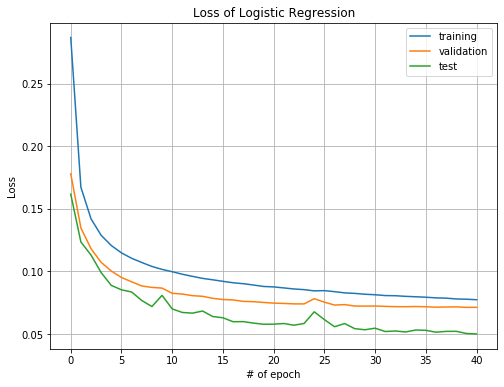

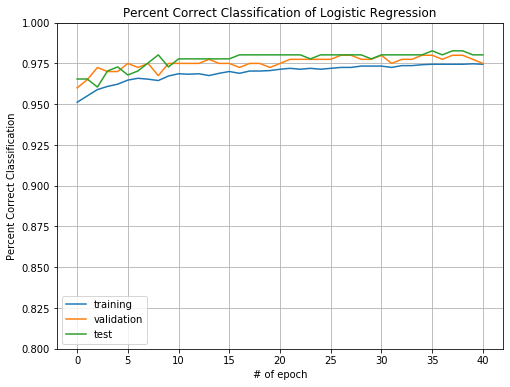

In [10]:
model23 = two_class_logistic_regression(trainD, trainL, testD, testL, valid_rate = VALID_RATE, learning_rate = LEARNING_RATE, \
                                        batchSize = BATCH_SIZE, lam = LAMBDA, regType = REGULARIZATION_TYPE, maxIter = MAX_ITERATION, \
                                        annealing_rate = ANNEALING_RATE, earlyStop = EARLY_STOP)

model23.fit()

print ('The error rate when it is lowest on validation set: \n train: %7.4f;\n validation: %7.4f;\n test: %7.4f.' \
       % (model23.best_err[0], model23.best_err[1], model23.best_err[2]))

model23.plot_loss()

model23.plot_acc()
plt.show()

In [11]:
trainD, trainL, testD, testL = data.targetSelect(2,8)

Training set loss after 1 epoch:  0.3216
Training set loss after 10 epoch:  0.1106
Training set loss after 20 epoch:  0.0954
Training set loss after 30 epoch:  0.0885
EarlyStop after 32 epochs.
The error rate when it is lowest on validation set: 
 train:  0.0291;
 validation:  0.0312;
 test:  0.0338.


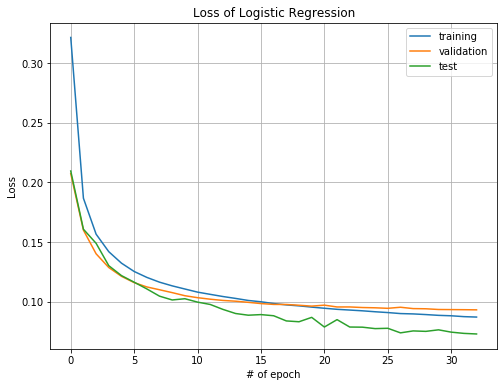

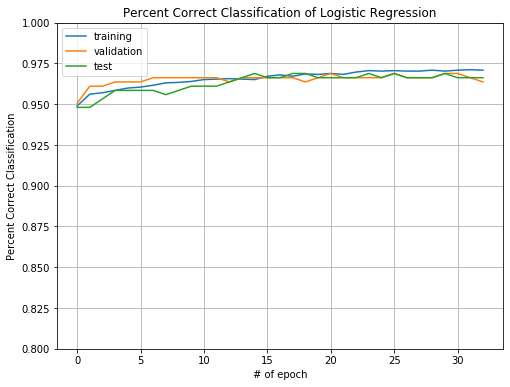

In [12]:
model28 = two_class_logistic_regression(trainD, trainL, testD, testL, valid_rate = VALID_RATE, learning_rate = LEARNING_RATE, \
                                        batchSize = BATCH_SIZE, lam = LAMBDA, regType = REGULARIZATION_TYPE, maxIter = MAX_ITERATION, \
                                        annealing_rate = ANNEALING_RATE, earlyStop = EARLY_STOP)

model28.fit()

print ('The error rate when it is lowest on validation set: \n train: %7.4f;\n validation: %7.4f;\n test: %7.4f.' \
       % (model28.best_err[0], model28.best_err[1], model28.best_err[2]))

model28.plot_loss()

model28.plot_acc()
plt.show()

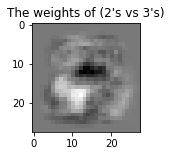

In [13]:
img = np.reshape(model23.weight[1:],(28,28))
plt.figure(figsize = (2.0,2.0))
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of (2\'s vs 3\'s)')
plt.show()

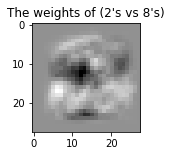

In [14]:
img = np.reshape(model28.weight[1:],(28,28))
plt.figure(figsize = (2.0,2.0))
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of (2\'s vs 8\'s)')
plt.show()

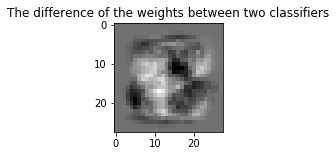

In [15]:
img = np.reshape(model23.weight[1:] - model28.weight[1:],(28,28))
plt.figure(figsize = (2.0,2.0))
plt.imshow(img, cmap=cm.gray)
plt.title('The difference of the weights between two classifiers')
plt.show()

# Regularization

## Model performance with different lambda using L2 regularization

In [16]:
trainD, trainL, testD, testL = data.targetSelect(2,3)

In [17]:
# Hyperparameters
VALID_RATE = 0.1
LEARNING_RATE = 5e-7
BATCH_SIZE = len(trainD) / 100
MAX_ITERATION = 100
EARLY_STOP = True
ANNEALING_RATE = 0.0
REGULARIZATION_TYPE = 'l2'

In [18]:
trainErrDict = defaultdict(list)
testErrDict = defaultdict(list)
weightDict = defaultdict(list)
for lam in [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]:
    print ('lambda is: %7.5f' % lam)
    model = two_class_logistic_regression(trainD, trainL, testD, testL, valid_rate = VALID_RATE, learning_rate = LEARNING_RATE, \
                                      batchSize = BATCH_SIZE, lam = lam, regType = REGULARIZATION_TYPE, maxIter = MAX_ITERATION, \
                                      annealing_rate = ANNEALING_RATE, earlyStop = EARLY_STOP)
    model.fit()
    testErrDict[lam] = model.err['test']
    trainErrDict[lam] = model.err['train']
    weightDict[lam] = model.weight

lambda is: 0.00100
Training set loss after 1 epoch:  0.2874
Training set loss after 10 epoch:  0.1017
Training set loss after 20 epoch:  0.0883
Training set loss after 30 epoch:  0.0819
Training set loss after 40 epoch:  0.0779
EarlyStop after 48 epochs.
lambda is: 0.01000
Training set loss after 1 epoch:  0.2879
Training set loss after 10 epoch:  0.1016
Training set loss after 20 epoch:  0.0885
Training set loss after 30 epoch:  0.0819
Training set loss after 40 epoch:  0.0777
Training set loss after 50 epoch:  0.0748
Training set loss after 60 epoch:  0.0722
Training set loss after 70 epoch:  0.0702
Training set loss after 80 epoch:  0.0685
EarlyStop after 81 epochs.
lambda is: 0.10000
Training set loss after 1 epoch:  0.2862
Training set loss after 10 epoch:  0.1018
Training set loss after 20 epoch:  0.0883
Training set loss after 30 epoch:  0.0819
Training set loss after 40 epoch:  0.0778
EarlyStop after 44 epochs.
lambda is: 10.00000
Training set loss after 1 epoch:  0.2874
Traini

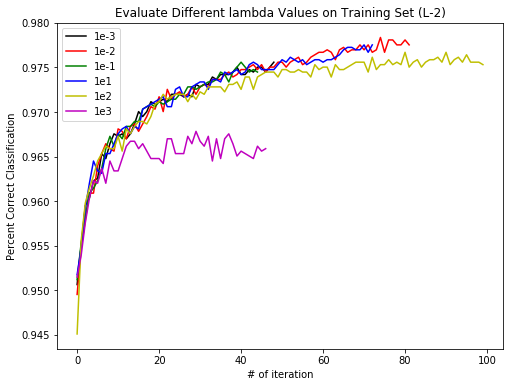

In [19]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(trainErrDict[1e-3]))], 1 - np.asarray(trainErrDict[1e-3]), '-k')
RLam2, = plt.plot([i for i in range(len(trainErrDict[1e-2]))], 1 - np.asarray(trainErrDict[1e-2]), '-r')
RLam3, = plt.plot([i for i in range(len(trainErrDict[1e-1]))], 1 - np.asarray(trainErrDict[1e-1]), '-g')
RLam4, = plt.plot([i for i in range(len(trainErrDict[1e1]))], 1 - np.asarray(trainErrDict[1e1]), '-b')
RLam5, = plt.plot([i for i in range(len(trainErrDict[1e2]))], 1 - np.asarray(trainErrDict[1e2]), '-y')
RLam6, = plt.plot([i for i in range(len(trainErrDict[1e3]))], 1 - np.asarray(trainErrDict[1e3]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Training Set (L-2)')
plt.show()

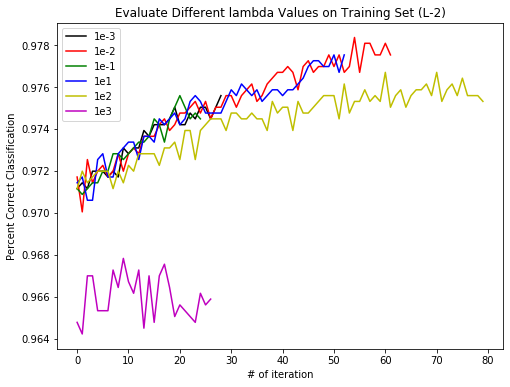

In [20]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(trainErrDict[1e-3][20:]))], 1 - np.asarray(trainErrDict[1e-3][20:]), '-k')
RLam2, = plt.plot([i for i in range(len(trainErrDict[1e-2][20:]))], 1 - np.asarray(trainErrDict[1e-2][20:]), '-r')
RLam3, = plt.plot([i for i in range(len(trainErrDict[1e-1][20:]))], 1 - np.asarray(trainErrDict[1e-1][20:]), '-g')
RLam4, = plt.plot([i for i in range(len(trainErrDict[1e1][20:]))], 1 - np.asarray(trainErrDict[1e1][20:]), '-b')
RLam5, = plt.plot([i for i in range(len(trainErrDict[1e2][20:]))], 1 - np.asarray(trainErrDict[1e2][20:]), '-y')
RLam6, = plt.plot([i for i in range(len(trainErrDict[1e3][20:]))], 1 - np.asarray(trainErrDict[1e3][20:]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Training Set (L-2)')
plt.show()

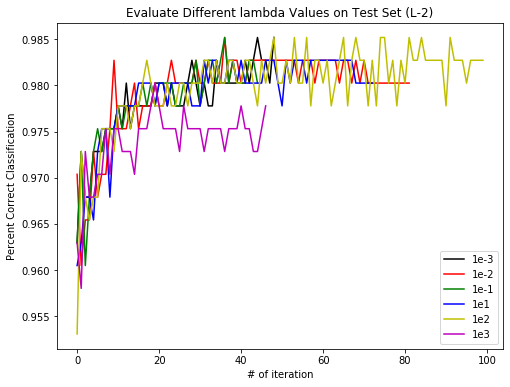

In [21]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(testErrDict[1e-3]))], 1 - np.asarray(testErrDict[1e-3]), '-k')
RLam2, = plt.plot([i for i in range(len(testErrDict[1e-2]))], 1 - np.asarray(testErrDict[1e-2]), '-r')
RLam3, = plt.plot([i for i in range(len(testErrDict[1e-1]))], 1 - np.asarray(testErrDict[1e-1]), '-g')
RLam4, = plt.plot([i for i in range(len(testErrDict[1e1]))], 1 - np.asarray(testErrDict[1e1]), '-b')
RLam5, = plt.plot([i for i in range(len(testErrDict[1e2]))], 1 - np.asarray(testErrDict[1e2]), '-y')
RLam6, = plt.plot([i for i in range(len(testErrDict[1e3]))], 1 - np.asarray(testErrDict[1e3]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Test Set (L-2)')
plt.show()

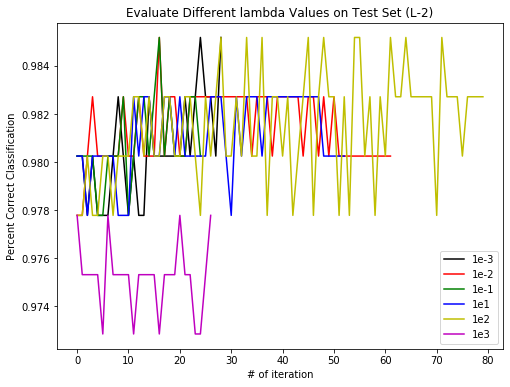

In [22]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(testErrDict[1e-3][20:]))], 1 - np.asarray(testErrDict[1e-3][20:]), '-k')
RLam2, = plt.plot([i for i in range(len(testErrDict[1e-2][20:]))], 1 - np.asarray(testErrDict[1e-2][20:]), '-r')
RLam3, = plt.plot([i for i in range(len(testErrDict[1e-1][20:]))], 1 - np.asarray(testErrDict[1e-1][20:]), '-g')
RLam4, = plt.plot([i for i in range(len(testErrDict[1e1][20:]))], 1 - np.asarray(testErrDict[1e1][20:]), '-b')
RLam5, = plt.plot([i for i in range(len(testErrDict[1e2][20:]))], 1 - np.asarray(testErrDict[1e2][20:]), '-y')
RLam6, = plt.plot([i for i in range(len(testErrDict[1e3][20:]))], 1 - np.asarray(testErrDict[1e3][20:]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Test Set (L-2)')
plt.show()

## Model performance with different lambda using L1 regularization

In [23]:
# Hyperparameters
VALID_RATE = 0.1
LEARNING_RATE = 5e-7
BATCH_SIZE = len(trainD) / 100
MAX_ITERATION = 100
EARLY_STOP = True
ANNEALING_RATE = 0.0
REGULARIZATION_TYPE = 'l1'

In [24]:
trainErrDict = defaultdict(list)
testErrDict = defaultdict(list)
weightDict = defaultdict(list)
for lam in [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]:
    print ('lambda is: %7.5f' % lam)
    model = two_class_logistic_regression(trainD, trainL, testD, testL, valid_rate = VALID_RATE, learning_rate = LEARNING_RATE, \
                                      batchSize = BATCH_SIZE, lam = lam, regType = REGULARIZATION_TYPE, maxIter = MAX_ITERATION, \
                                      annealing_rate = ANNEALING_RATE, earlyStop = EARLY_STOP)
    model.fit()
    testErrDict[lam] = model.err['test']
    trainErrDict[lam] = model.err['train']
    weightDict[lam] = model.weight

lambda is: 0.00100
Training set loss after 1 epoch:  0.2862
Training set loss after 10 epoch:  0.1017
Training set loss after 20 epoch:  0.0883
Training set loss after 30 epoch:  0.0822
Training set loss after 40 epoch:  0.0778
EarlyStop after 44 epochs.
lambda is: 0.01000
Training set loss after 1 epoch:  0.2867
Training set loss after 10 epoch:  0.1017
Training set loss after 20 epoch:  0.0886
Training set loss after 30 epoch:  0.0823
Training set loss after 40 epoch:  0.0784
EarlyStop after 47 epochs.
lambda is: 0.10000
Training set loss after 1 epoch:  0.2884
Training set loss after 10 epoch:  0.1042
Training set loss after 20 epoch:  0.0919
Training set loss after 30 epoch:  0.0864
Training set loss after 40 epoch:  0.0830
Training set loss after 50 epoch:  0.0806
Training set loss after 60 epoch:  0.0787
Training set loss after 70 epoch:  0.0771
Training set loss after 80 epoch:  0.0759
Training set loss after 90 epoch:  0.0748
Training set loss after 100 epoch:  0.0738
lambda is

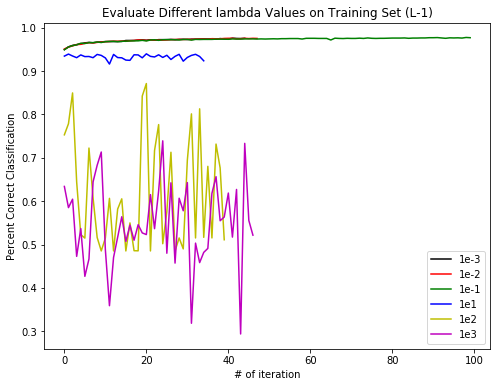

In [25]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(trainErrDict[1e-3]))], 1 - np.asarray(trainErrDict[1e-3]), '-k')
RLam2, = plt.plot([i for i in range(len(trainErrDict[1e-2]))], 1 - np.asarray(trainErrDict[1e-2]), '-r')
RLam3, = plt.plot([i for i in range(len(trainErrDict[1e-1]))], 1 - np.asarray(trainErrDict[1e-1]), '-g')
RLam4, = plt.plot([i for i in range(len(trainErrDict[1e1]))], 1 - np.asarray(trainErrDict[1e1]), '-b')
RLam5, = plt.plot([i for i in range(len(trainErrDict[1e2]))], 1 - np.asarray(trainErrDict[1e2]), '-y')
RLam6, = plt.plot([i for i in range(len(trainErrDict[1e3]))], 1 - np.asarray(trainErrDict[1e3]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Training Set (L-1)')
plt.show()

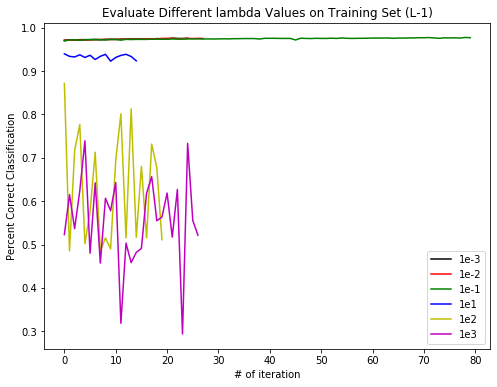

In [26]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(trainErrDict[1e-3][20:]))], 1 - np.asarray(trainErrDict[1e-3][20:]), '-k')
RLam2, = plt.plot([i for i in range(len(trainErrDict[1e-2][20:]))], 1 - np.asarray(trainErrDict[1e-2][20:]), '-r')
RLam3, = plt.plot([i for i in range(len(trainErrDict[1e-1][20:]))], 1 - np.asarray(trainErrDict[1e-1][20:]), '-g')
RLam4, = plt.plot([i for i in range(len(trainErrDict[1e1][20:]))], 1 - np.asarray(trainErrDict[1e1][20:]), '-b')
RLam5, = plt.plot([i for i in range(len(trainErrDict[1e2][20:]))], 1 - np.asarray(trainErrDict[1e2][20:]), '-y')
RLam6, = plt.plot([i for i in range(len(trainErrDict[1e3][20:]))], 1 - np.asarray(trainErrDict[1e3][20:]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Training Set (L-1)')
plt.show()

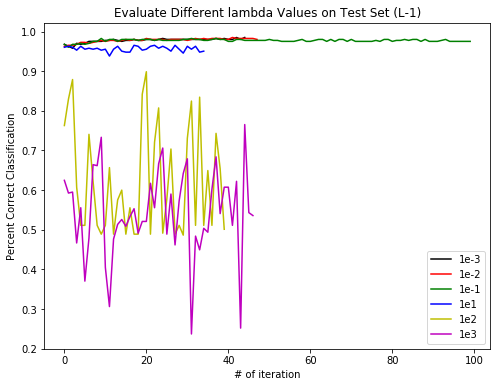

In [27]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(testErrDict[1e-3]))], 1 - np.asarray(testErrDict[1e-3]), '-k')
RLam2, = plt.plot([i for i in range(len(testErrDict[1e-2]))], 1 - np.asarray(testErrDict[1e-2]), '-r')
RLam3, = plt.plot([i for i in range(len(testErrDict[1e-1]))], 1 - np.asarray(testErrDict[1e-1]), '-g')
RLam4, = plt.plot([i for i in range(len(testErrDict[1e1]))], 1 - np.asarray(testErrDict[1e1]), '-b')
RLam5, = plt.plot([i for i in range(len(testErrDict[1e2]))], 1 - np.asarray(testErrDict[1e2]), '-y')
RLam6, = plt.plot([i for i in range(len(testErrDict[1e3]))], 1 - np.asarray(testErrDict[1e3]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Test Set (L-1)')
plt.show()

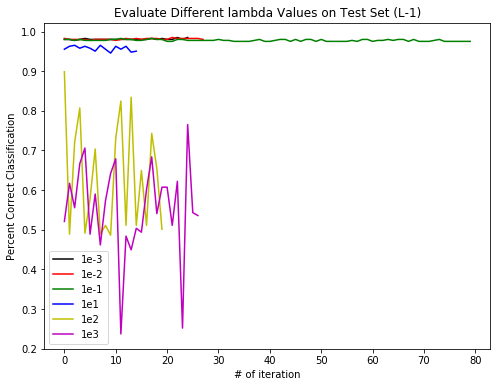

In [28]:
plt.figure(figsize = (8,6))
RLam1, = plt.plot([i for i in range(len(testErrDict[1e-3][20:]))], 1 - np.asarray(testErrDict[1e-3][20:]), '-k')
RLam2, = plt.plot([i for i in range(len(testErrDict[1e-2][20:]))], 1 - np.asarray(testErrDict[1e-2][20:]), '-r')
RLam3, = plt.plot([i for i in range(len(testErrDict[1e-1][20:]))], 1 - np.asarray(testErrDict[1e-1][20:]), '-g')
RLam4, = plt.plot([i for i in range(len(testErrDict[1e1][20:]))], 1 - np.asarray(testErrDict[1e1][20:]), '-b')
RLam5, = plt.plot([i for i in range(len(testErrDict[1e2][20:]))], 1 - np.asarray(testErrDict[1e2][20:]), '-y')
RLam6, = plt.plot([i for i in range(len(testErrDict[1e3][20:]))], 1 - np.asarray(testErrDict[1e3][20:]), '-m')
plt.legend([RLam1, RLam2, RLam3, RLam4, RLam5, RLam6], ['1e-3', '1e-2', '1e-1', '1e1', '1e2', '1e3'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Evaluate Different lambda Values on Test Set (L-1)')
plt.show()

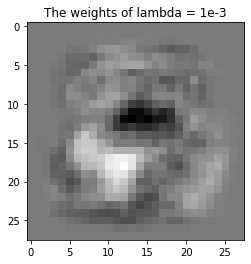

In [29]:
img = np.reshape(weightDict[1e-3][1:],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of lambda = 1e-3')
plt.show()

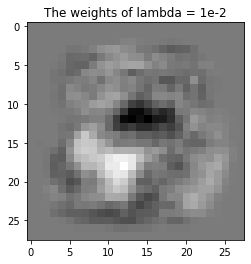

In [30]:
img = np.reshape(weightDict[1e-2][1:],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of lambda = 1e-2')
plt.show()

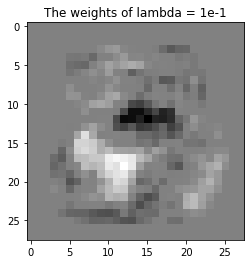

In [31]:
img = np.reshape(weightDict[1e-1][1:],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of lambda = 1e-1')
plt.show()

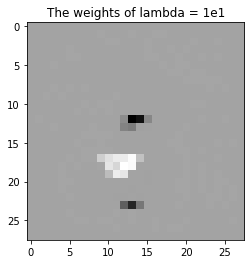

In [32]:
img = np.reshape(weightDict[1e1][1:],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of lambda = 1e1')
plt.show()

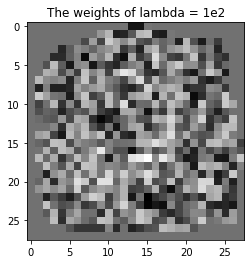

In [33]:
img = np.reshape(weightDict[1e2][1:],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of lambda = 1e2')
plt.show()



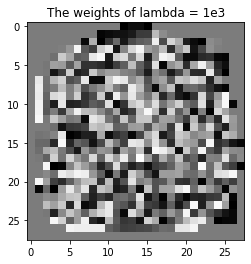

In [34]:
img = np.reshape(weightDict[1e3][1:],(28,28))
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.title('The weights of lambda = 1e3')
plt.show()

In [35]:
weightDict[1e-3][1:].T.dot(weightDict[1e-3][1:])[0][0]

0.0001878646594322279

In [36]:
weightDict[1e-2][1:].T.dot(weightDict[1e-2][1:])[0][0]

0.00019061711002128876

In [37]:
weightDict[1e-1][1:].T.dot(weightDict[1e-1][1:])[0][0]

0.0002198522868984836

In [38]:
weightDict[1e1][1:].T.dot(weightDict[1e1][1:])[0][0]

2.1300406452003242e-05

In [39]:
weightDict[1e2][1:].T.dot(weightDict[1e2][1:])[0][0]

6.000591429393401e-07

In [40]:
weightDict[1e3][1:].T.dot(weightDict[1e3][1:])[0][0]

5.4908638542932516e-05

# Softmax Regression via Gradient Descent

In [41]:
class softmax_regression():
    def __init__(self, trainD, trainL, testD, testL, valid_rate = 0.1, batchSize = 1, learning_rate = 1e-3, \
                 maxIter = 200, annealing_rate = 2e8, lam = 0.0, regType = 'l2', earlyStop = False):
        self.classNum = len(trainL[0])
        self.validLen = int(len(trainD) * valid_rate)
        self.trainD = trainD[self.validLen:]
        self.trainL = trainL[self.validLen:]
        self.validD = trainD[:self.validLen]
        self.validL = trainL[:self.validLen]
        self.testD = testD
        self.testL = testL
        self.batchSize = int(batchSize)
        self.lr = learning_rate
        self.maxIter = maxIter
        self.ar = annealing_rate
        self.lam = lam
        self.regType = regType
        self.earlyStop = earlyStop
        self.loss = defaultdict(list)
        self.err = defaultdict(list)
#         self.weight = 1 / np.sqrt(len(trainD[0])) * np.random.randn(len(trainD[0]),self.classNum)
        self.weight = np.zeros((len(trainD[0]), self.classNum))
        self.best_err = 1.0
    
    def softMax(self, x):
        x = np.exp(x)
        return x / np.sum(x, axis = 1, keepdims = True)
    
    def fit(self):
        best_err = np.ones((3,1))
        best_weight = np.zeros((len(self.trainD[0]),self.classNum))
        epoch = 0
        trainLen = len(self.trainD)
        while epoch < self.maxIter:
            idx = np.random.permutation(trainLen)
            if self.ar:
                lr = self.lr / (1.0 + epoch / self.ar)
            else:
                lr = self.lr
            for startIdx in range(0, trainLen, self.batchSize):
                endIdx = startIdx + self.batchSize
                if endIdx >= trainLen:
                    endIdx = trainLen
                trainD = self.trainD[idx[startIdx:endIdx]]
                trainL = self.trainL[idx[startIdx:endIdx]]
                a = trainD.dot(self.weight)
                y = self.softMax(a)
                derE = trainD.T.dot(y - trainL) / len(trainD)
                if self.regType == 'l2':
                    derC = 2.0 * self.weight[1:]
                else:
                    derC = np.copy(self.weight[1:])
                    derC[derC > 0] = 1.0
                    derC[derC < 0] = -1.0
                derC = np.insert(derC, 0, 0.0, axis = 0)
                derJ = derE + self.lam * derC
                self.weight -= lr * derJ
                
            self.loss['train'].append(self.cal_loss(self.trainD, self.trainL))
            self.loss['valid'].append(self.cal_loss(self.validD, self.validL))
            self.loss['test'].append(self.cal_loss(self.testD, self.testL))
            self.err['train'].append(self.cal_err(self.trainD, self.trainL))
            self.err['valid'].append(self.cal_err(self.validD, self.validL))
            self.err['test'].append(self.cal_err(self.testD, self.testL))
            
            if epoch == 0 or epoch % 10 == 9:
                print ('Training set loss after %d epoch: %7.4f' % (epoch + 1, self.loss['train'][-1]))
            
            if best_err[1] >= self.err['valid'][-1]:
                best_err[0] = self.err['train'][-1]
                best_err[1] = self.err['valid'][-1]
                best_err[2] = self.err['test'][-1]
                best_weight = self.weight
            
            if self.earlyStop:
                if len(self.err['valid']) >= 40 and self.err['valid'][-1] > self.err['valid'][-2] > self.err['valid'][-3]:
                    print ("EarlyStop after %d epochs." % (epoch))
                    break
            
            epoch += 1
                    
        self.weight = best_weight
        self.best_err = best_err
        
    def cal_loss(self, data, label):
        a = data.dot(self.weight)
        a = self.softMax(a)
        predict = a / np.sum(a, axis = 1, keepdims = True)
        loss = -1.0 * np.sum(np.nan_to_num(label * np.log(predict)))
        if self.regType == 'l2':
            loss += self.lam * np.sum(np.power(self.weight[1:], 2))
        if self.regType == 'l1':
            loss += self.lam * np.sum(np.absolute(self.weight[1:]))
        loss = loss / len(data)
        return loss
    
    def cal_err(self, data, label):
        a = data.dot(self.weight)
        a = self.softMax(a)
        predict = np.argmax(a, axis = 1).reshape((len(data), -1))
        label = np.argmax(label, axis = 1).reshape((len(label),-1))
        err = 1.0 * np.sum([a != b for (a, b) in zip(predict, label)]) / len(label)
        return err
    
    def plot_loss(self, title = 'Loss of Logistic Regression'):
        x = [i for i in range(len(self.loss['valid']))]
        plt.figure(figsize = (8,6))
        trainLoss, = plt.plot(x, self.loss['train'])
        validLoss, = plt.plot(x, self.loss['valid'])
        testLoss, = plt.plot(x, self.loss['test'])
        plt.legend([trainLoss, validLoss, testLoss], ['training', 'validation', 'test'])
        plt.xlabel('# of epoch')
        plt.ylabel('Loss')
        #plt.ylim([0.0, 0.5])
        plt.grid(True)
        plt.title(title)
        
    def plot_acc(self, title = 'Percent Correct Classification of Logistic Regression'):
        x = [i for i in range(len(self.err['valid']))]
        plt.figure(figsize = (8,6))
        trainAcc, = plt.plot(x, 1.0 - np.array(self.err['train']))
        validAcc, = plt.plot(x, 1.0 - np.array(self.err['valid']))
        testAcc, = plt.plot(x, 1.0 - np.array(self.err['test']))
        plt.legend([trainAcc, validAcc, testAcc], ['training', 'validation', 'test'])
        plt.xlabel('# of epoch')
        plt.ylabel('Percent Correct Classification')
        #plt.ylim([0.8, 1.0])
        plt.grid(True)
        plt.title(title)

In [42]:
trainD, testD = data.trainData, data.testData
trainL, testL = data.oneHot()

In [45]:
# Hyperparameters
VALID_RATE = 0.1
LEARNING_RATE = 1e-6
LAMBDA = 1e-4
BATCH_SIZE = 100
MAX_ITERATION = 200
EARLY_STOP = True
ANNEALING_RATE = 2e9
REGULARIZATION_TYPE = 'l2'

Training set loss after 1 epoch:  0.5745
Training set loss after 10 epoch:  0.3315
Training set loss after 20 epoch:  0.2970
Training set loss after 30 epoch:  0.2803
Training set loss after 40 epoch:  0.2696
EarlyStop after 45 epochs.
The error rate when it is lowest on validation set: 
 train:  0.0720;
 validation:  0.0800;
 test:  0.0585.


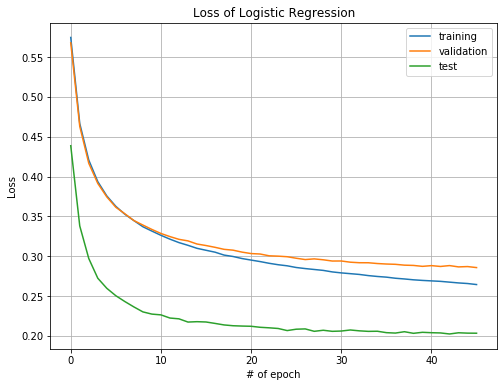

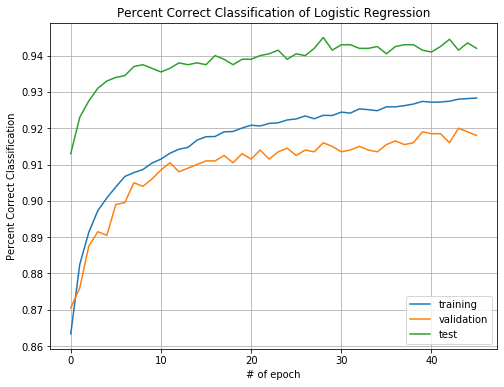

In [46]:
model = softmax_regression(trainD, trainL, testD, testL, valid_rate = VALID_RATE, learning_rate = LEARNING_RATE, \
                                        batchSize = BATCH_SIZE, lam = LAMBDA, regType = REGULARIZATION_TYPE, maxIter = MAX_ITERATION, \
                                        annealing_rate = ANNEALING_RATE, earlyStop = EARLY_STOP)

model.fit()

print ('The error rate when it is lowest on validation set: \n train: %7.4f;\n validation: %7.4f;\n test: %7.4f.' \
       % (model.best_err[0], model.best_err[1], model.best_err[2]))

model.plot_loss()

model.plot_acc()
plt.show()

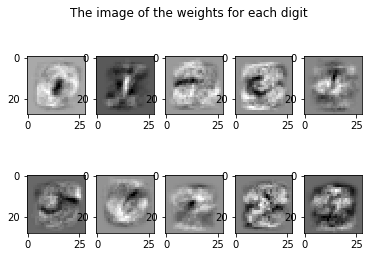

In [47]:
for i in range(10):
    weight = np.reshape(model.weight[1:,i], (28,28))
    plt.subplot(2,5,i+1)
    plt.imshow(weight, cmap=cm.gray)
plt.suptitle('The image of the weights for each digit')
plt.show()

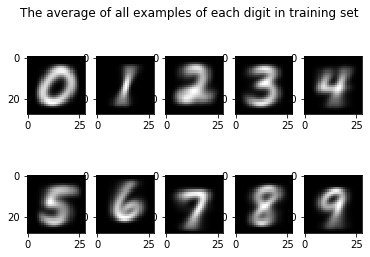

In [48]:
from collections import defaultdict
classes = defaultdict(list)
i = 0
for d, label in zip(data.trainData, data.trainLabel):
    classes[label[0]].append(d)
    i += 1

for i in range(10):
    digit = sum(classes[i]) / len(classes[i])
    digit = np.reshape(digit[1:],(28,28))
    plt.subplot(2,5,i+1)
    plt.imshow(digit, cmap=cm.gray)
plt.suptitle('The average of all examples of each digit in training set')
plt.show()